#Bootstrap + Hidden Markov Models (HMM) — Flechas 9×9



El siguiente programa permite clasificar matrices binarias de 9x9 (que representan imagenes en blanco y negro), en cuatro categorías distintas de flechas (arriba, abajo, izquierda, derecha), mediante el uso de HMM.

In [ ]:
using Pkg
Pkg.add(["Plots","Images","ImageShow","Statistics"])


    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
   Installed Libmount_jll ───────────────────── v2.41.2+0
   Installed ImageMagick ────────────────────── v1.4.2
   Installed ImageSegmentation ──────────────── v1.9.0
   Installed TiledIteration ─────────────────── v0.5.0
   Installed NearestNeighbors ───────────────── v0.4.22
   Installed LuxLib ─────────────────────────── v1.12.1
   Installed HistogramThresholding ──────────── v0.3.1
   Installed RegionTrees ────────────────────── v0.3.2
   Installed RealDot ────────────────────────── v0.1.0
   Installed Distances ──────────────────────── v0.10.12
   Installed SLEEFPirates ───────────────────── v0.6.43
   Installed JLD2 ───────────────────────────── v0.5.15
   Installed Polynomials ────────────────────── v4.1.0
   Installed LuxCore ────────────────────────── v1.4.2
   Installed Images ─────────────────────────── v0.26.2
   Installed MetaGraphs ─────────────────────── v0.8.1
   Installed Arno

In [ ]:
Pkg.add("ImageCore")

In [ ]:
using Random
using LinearAlgebra
using Statistics
using Plots
using Images, ImageCore


## 1) Define Patrones:
 Se crean cuatro "imágenes" perfectas de 9x9 píxeles (matrices de 0s y 1s) que representan las cuatro direcciones de las flechas.

In [ ]:
function pattern_from_strings(lines::Vector{String})
    n = length(lines)
    M = zeros(Int, n, n)
    for i in 1:n
        for j in 1:n
            M[i,j] = lines[i][j] == '1' ? 1 : 0
        end
    end
    return M
end

N = 9
up_pat = [
  "000010000",
  "000111000",
  "001010100",
  "000010000",
  "000010000",
  "000010000",
  "000010000",
  "000010000",
  "000010000"
]

up = pattern_from_strings(up_pat)
down = reverse(up, dims=1)
function rot90cw(M)
    return reverse(permutedims(M, (2,1)), dims=2)
end
function rot90ccw(M)
    return reverse(permutedims(M, (2,1)), dims=1)
end
right = rot90cw(up)
left = rot90ccw(up)

# Mostrar plantillas (texto)
for (name, M) in zip(["up","down","left","right"], [up,down,left,right])
    println("\nPlantilla: ", name)
    for i in 1:N
        println(join(string.(M[i,:]), ""))
    end
end


#2) Genera Datos de Entrenamiento:
Crea un conjunto de datos sintético. Toma los patrones perfectos y les añade "ruido" (invierte aleatoriamente algunos píxeles) para simular imágenes imperfectas.

In [ ]:

function add_noise(M::Array{Int,2}; p::Float64=0.05)
    R = copy(M)
    for idx in eachindex(R)
        if rand() < p
            R[idx] = 1 - R[idx]
        end
    end
    return R
end

function mat_to_obs(M::Array{Int,2})
    v = vec(transpose(M))  # aplana por filas: fila-major
    return [x==0 ? 1 : 2 for x in v] #por lo de indexación
end

function gen_samples(pattern::Array{Int,2}, n::Int; noise::Float64=0.05)
    seqs = Vector{Vector{Int}}()
    mats = Vector{Array{Int,2}}()
    for i in 1:n
        M = add_noise(pattern, p=noise)
        push!(mats, M)
        push!(seqs, mat_to_obs(M))
    end
    return seqs, mats
end


## 3) Implementación HMM  — Forward/Backward escalado y Baum–Welch

Implementamos funciones para entrenamiento y evaluación.


In [ ]:
epsval() = eps(Float64) #evita errores de div por cero
function init_hmm(K::Int, M::Int)
    A = rand(K,K)
    A .= A ./ sum(A, dims=2)
    B = rand(K,M)
    B .= B ./ sum(B, dims=2)
    π = rand(K)
    π ./= sum(π)
    return A, B, π
end

function forward_scaled(O::Vector{Int}, A::Array{Float64,2}, B::Array{Float64,2}, π::Vector{Float64})
    K = size(A,1); T = length(O)
    α = zeros(Float64, K, T)
    c = zeros(Float64, T)
    for k in 1:K
        α[k,1] = π[k] * B[k, O[1]]
    end
    c[1] = sum(α[:,1])
    c[1] = c[1] == 0.0 ? epsval() : c[1]
    α[:,1] ./= c[1]
    for t in 2:T
        for k in 1:K
            α[k,t] = B[k, O[t]] * sum(α[:,t-1] .* A[:,k])
        end
        c[t] = sum(α[:,t])
        c[t] = c[t] == 0.0 ? epsval() : c[t]
        α[:,t] ./= c[t]
    end
    loglik = sum(log.(c))
    return α, c, loglik
end

function backward_scaled(O::Vector{Int}, A::Array{Float64,2}, B::Array{Float64,2}, c::Vector{Float64})
    K = size(A,1); T = length(O)
    β = zeros(Float64, K, T)
    β[:,T] .= 1.0
    β[:,T] ./= c[T]
    for t in (T-1):-1:1
        for i in 1:K
            s = 0.0
            for j in 1:K
                s += A[i,j] * B[j, O[t+1]] * β[j, t+1]
            end
            β[i,t] = s
        end
        β[:,t] ./= c[t]
    end
    return β
end

function compute_gamma_xi(O::Vector{Int}, A::Array{Float64,2}, B::Array{Float64,2}, π::Vector{Float64})
    α, c, loglik = forward_scaled(O,A,B,π)
    β = backward_scaled(O,A,B,c)
    K = size(A,1); T = length(O)
    gamma = zeros(Float64, K, T)
    xi = zeros(Float64, K, K, max(0,T-1))
    for t in 1:T
        denom = sum(α[:,t] .* β[:,t])
        denom = denom == 0.0 ? epsval() : denom
        gamma[:,t] = (α[:,t] .* β[:,t]) ./ denom
    end
    for t in 1:T-1
        denom = 0.0
        for i in 1:K, j in 1:K
            denom += α[i,t] * A[i,j] * B[j, O[t+1]] * β[j, t+1]
        end
        denom = denom == 0.0 ? epsval() : denom
        for i in 1:K, j in 1:K
            xi[i,j,t] = α[i,t] * A[i,j] * B[j, O[t+1]] * β[j, t+1] / denom
        end
    end
    return gamma, xi, loglik
end

function baum_welch(sequences::Vector{Vector{Int}}, K::Int; M::Int=2, max_iter::Int=50, tol::Float64=1e-4)
    A, B, π = init_hmm(K, M)
    prev_ll = -Inf
    for iter in 1:max_iter
        A_num = zeros(Float64, K, K)
        A_den = zeros(Float64, K)
        B_num = zeros(Float64, K, M)
        B_den = zeros(Float64, K)
        π_acc = zeros(Float64, K)
        total_loglik = 0.0
        for O in sequences
            gamma, xi, loglik = compute_gamma_xi(O, A, B, π)
            total_loglik += loglik
            T = length(O)
            π_acc .+= gamma[:,1]
            if T > 1
                for t in 1:(T-1)
                    A_num .+= xi[:,:,t]
                    A_den .+= gamma[:,t]
                end
            end
            for t in 1:T
                for k in 1:K
                    B_num[k, O[t]] += gamma[k,t]
                    B_den[k] += gamma[k,t]
                end
            end
        end
        π = π_acc ./ sum(π_acc)
        for i in 1:K
            for j in 1:K
                A[i,j] = A_den[i] == 0.0 ? 1.0/K : A_num[i,j] / (A_den[i] + epsval())
            end
            s = sum(A[i,:])
            A[i,:] ./= (s == 0.0 ? 1.0 : s)
        end
        for k in 1:K
            for v in 1:M
                B[k,v] = B_num[k,v] / (B_den[k] + epsval())
            end
            s = sum(B[k,:])
            B[k,:] ./= (s == 0.0 ? 1.0 : s)
        end
        if iter > 1 && abs(total_loglik - prev_ll) < tol * (abs(prev_ll) + epsval())
            println("Convergencia en iteración ", iter, ", loglik = ", total_loglik)
            break
        end
        prev_ll = total_loglik
    end
    return Dict(:A=>A, :B=>B, :π=>π, :loglik=>prev_ll)
end

function model_loglik(O::Vector{Int}, model::Dict)
    _, _, loglik = forward_scaled(O, model[:A], model[:B], model[:π])
    return loglik
end


model_loglik (generic function with 1 method)

## 4) Dataset, entrenamiento y evaluación

Genera datasets de entrenamiento y prueba, y entrena un HMM por clase



In [ ]:
Ntrain = 120
Ntest = 40
noise = 0.08
classes = Dict(1=>up, 2=>down, 3=>left, 4=>right)
train_seqs = Dict{Int, Vector{Vector{Int}}}()
train_mats = Dict{Int, Vector{Array{Int,2}}}()
test_seqs = Dict{Int, Vector{Vector{Int}}}()
test_mats = Dict{Int, Vector{Array{Int,2}}}()
for (lab, pat) in pairs(classes)
    s, ms = gen_samples(pat, Ntrain, noise=noise)
    train_seqs[lab] = s
    train_mats[lab] = ms
    Random.seed!(1234 + lab)
    ts, tms = gen_samples(pat, Ntest, noise=noise)
    test_seqs[lab] = ts
    test_mats[lab] = tms
end
println("Dataset creado. Ejemplos por clase (train/test):")
for lab in sort(collect(keys(classes)))
    println("Clase $lab: train=$(length(train_seqs[lab])) test=$(length(test_seqs[lab]))")
end

K = 6  # estados ocultos
models = Dict{Int, Dict}()
for lab in sort(collect(keys(classes)))
    println("Entrenando clase $lab...")
    models[lab] = baum_welch(train_seqs[lab], K; M=2, max_iter=60)
    println("  loglik entreno (aprox): ", models[lab][:loglik])
end

function evaluate_models(models, test_seqs)
    total = 0; correct = 0
    perclass = Dict{Int, Tuple{Int,Int}}()
    for lab in keys(test_seqs)
        perclass[lab] = (0,0)
    end
    lablist = sort(collect(keys(models)))
    for lab in lablist
        for O in test_seqs[lab]
            scores = [model_loglik(O, models[k]) for k in lablist]
            idx = findmax(scores)[2]
            pred = lablist[idx]
            total += 1
            if pred == lab
                correct += 1
                perclass[lab] = (perclass[lab][1]+1, perclass[lab][2]+1)
            else
                perclass[lab] = (perclass[lab][1], perclass[lab][2]+1)
            end
        end
    end
    return correct/total, perclass
end

acc, perclass = evaluate_models(models, test_seqs)
println("Accuracy en test: ", round(acc*100, digits=2), "%")
for (k,v) in sort(collect(perclass))
    println("Clase $k: correct=$(v[1]) / total=$(v[2]) => ", round(100*v[1]/v[2], digits=2), "%")
end


Dataset creado. Ejemplos por clase (train/test):
Clase 1: train=120 test=40
Clase 2: train=120 test=40
Clase 3: train=120 test=40
Clase 4: train=120 test=40
Entrenando clase 1...
Convergencia en iteración 6, loglik = -5068.491744846146
  loglik entreno (aprox): -5068.868129255203
Entrenando clase 2...
Convergencia en iteración 6, loglik = -5100.243744021121
  loglik entreno (aprox): -5100.748837040401
Entrenando clase 3...
Convergencia en iteración 20, loglik = -4270.44304179025
  loglik entreno (aprox): -4270.853703207325
Entrenando clase 4...
  loglik entreno (aprox): -4151.960639392751
Accuracy en test: 58.75%
Clase 1: correct=36 / total=40 => 90.0%
Clase 2: correct=4 / total=40 => 10.0%
Clase 3: correct=24 / total=40 => 60.0%
Clase 4: correct=30 / total=40 => 75.0%


## 5) Bootstrap (reentrenar sobre remuestreos del training set)
 Cada remuestreo reentrena modelos por clase
y evalúa en el conjunto de prueba fijo.


In [ ]:
B = 20
boot_accs = Float64[]
boot_perclass = Dict{Int, Vector{Float64}}()
for k in keys(classes)
    boot_perclass[k] = Float64[]
end

for b in 1:B
    # remuestreo por clase del conjunto de entrenamiento
    boot_train = Dict{Int, Vector{Vector{Int}}}()
    for (lab, seqs) in pairs(train_seqs)
        n = length(seqs)
        idxs = [rand(1:n) for _ in 1:n]
        boot_train[lab] = [seqs[i] for i in idxs]
    end
    # entrenar modelos para este bootstrap
    boot_models = Dict{Int, Dict}()
    for lab in keys(classes)
        boot_models[lab] = baum_welch(boot_train[lab], K; M=2, max_iter=40)
    end
    # evaluar
    acc_b, perclass_b = evaluate_models(boot_models, test_seqs)
    push!(boot_accs, acc_b)
    for (k,v) in perclass_b
        c, t = v
        push!(boot_perclass[k], t == 0 ? 0.0 : c / t)
    end
    if b % 20 == 0
        println("Bootstrap $b/$B  acc=$(round(acc_b*100,digits=2))%")
    end
end
println("Bootstrap completado. mean acc = ", round(mean(boot_accs)*100, digits=2), "%")


Convergencia en iteración 8, loglik = -5105.6398232946985
Convergencia en iteración 16, loglik = -4258.014345760311
Convergencia en iteración 16, loglik = -5050.737645238561
Convergencia en iteración 40, loglik = -4128.752379584623
Convergencia en iteración 5, loglik = -5089.910399358207
Convergencia en iteración 18, loglik = -4307.488038833173
Convergencia en iteración 15, loglik = -5068.889366912357
Convergencia en iteración 34, loglik = -5036.6905210469295
Convergencia en iteración 16, loglik = -4167.684472665471
Convergencia en iteración 20, loglik = -5072.72249510997
Convergencia en iteración 15, loglik = -4104.767693663487
Convergencia en iteración 35, loglik = -4321.608161093452
Convergencia en iteración 10, loglik = -5114.28259912905
Convergencia en iteración 7, loglik = -5055.749476850356
Convergencia en iteración 5, loglik = -5052.436463990862
Convergencia en iteración 40, loglik = -4169.1731162009955
Convergencia en iteración 20, loglik = -5047.869900287322
Convergencia en i

## 6) Visualización y análisis

- Histograma (bootstrap)
- Intervalos de confianza percentiles


Muestra (izquierda) a visualizar:
Clase 1 -> loglik = -46.85258028836053
Clase 2 -> loglik = -46.89277891598465
Clase 3 -> loglik = -41.38822006311844
Clase 4 -> loglik = -41.3050511942615


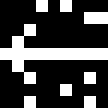

Clase 1 -> loglik = -53.05220453562258
Clase 2 -> loglik = -53.17120047932893
Clase 3 -> loglik = -57.170817369690894
Clase 4 -> loglik = -57.34833087938125


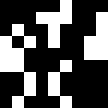

[0 0 0 1 0 1 0 0 0; 0 0 0 0 0 0 0 1 1; 0 0 1 0 0 0 0 0 0; 0 1 0 0 0 0 0 0 0; 1 1 1 1 1 1 1 1 1; 0 1 0 0 0 0 0 0 0; 0 0 1 0 0 0 0 1 0; 0 0 0 0 0 1 0 0 0; 0 0 1 0 0 0 0 1 0]


In [ ]:
#para ver como clasifica un ejemplp

function show_sample_and_scores(M::Array{Int,2}, models::Dict)
    O = mat_to_obs(M)
    scores = Dict(k => model_loglik(O, models[k]) for k in keys(models))
    # ordenar por label
    for k in sort(collect(keys(scores)))
        println("Clase $k -> loglik = ", scores[k])
    end
    # visualizar
    img = Gray.(Float64.(M))
    display(img)
end

# tomar una muestra ruidosa de 'left' y mostrar resultados
Msample = add_noise(left, p=0.06)
println("Muestra (izquierda) a visualizar:")
show_sample_and_scores(Msample, models)

show_sample_and_scores(add_noise(up, p=0.3), models)
println(Msample)

#Se elige el que tenga el valor más grande

In [ ]:
Pkg.add("StatsBase")

   Resolving package versions...
    Updating `~/.julia/environments/v1.11/Project.toml`
  [2913bbd2] + StatsBase v0.34.6
  No Changes to `~/.julia/environments/v1.11/Manifest.toml`


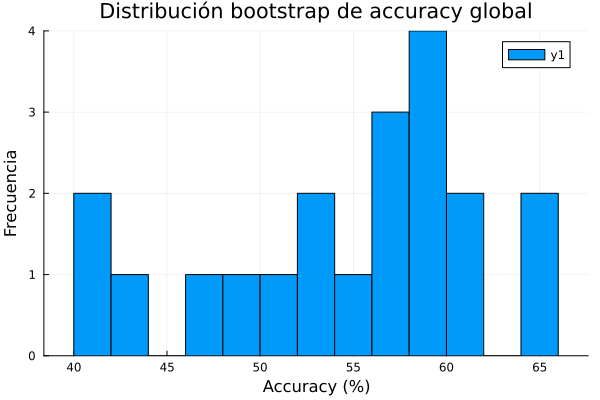

In [ ]:
using StatsBase, Plots

# Este gráfico se mostrará directamente en la salida
histogram(boot_accs .* 100, bins=20, xlabel="Accuracy (%)", ylabel="Frecuencia", title="Distribución bootstrap de accuracy global")
# savefig("hist_accuracy_global.png") # <--- LÍNEA DESACTIVADA


In [ ]:

println("IC95 global (percentiles): ", quantile(boot_accs, [0.025, 0.975]))

for k in sort(collect(keys(boot_perclass)))
    ci = quantile(boot_perclass[k], [0.025, 0.975])
    println("Clase $k IC95 (percentiles): ", ci)

    histogram(boot_perclass[k] .* 100, bins=20, xlabel="Accuracy (%)", title="Bootstrap accuracy - clase $k")

end


IC95 global (percentiles): [0.40921874999999996, 0.6470312500000001]
Clase 1 IC95 (percentiles): [0.061875, 0.9]
Clase 2 IC95 (percentiles): [0.036875000000000005, 0.8512499999999998]
Clase 3 IC95 (percentiles): [0.335625, 0.8381249999999999]
Clase 4 IC95 (percentiles): [0.375, 0.813125]
